# Objective
#### Determine whether the given reviews are positive or negative using all features except SCORE and then check the accuracy using the Score feature using KNN classifier

# 1. Loading data from dataset

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import nltk
import seaborn as sns

In [2]:
# Loading data from sqlite3 database ignoring those having rewiew score = 3

connection = sqlite3.connect('./database.sqlite')
dataset = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3", connection)

In [3]:
print("The shape of the data in dataset is:", dataset.shape)
print('==' * 60)
dataset.columns                # This will list all the features name in dataset column-wise

The shape of the data in dataset is: (525814, 10)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [4]:
# Assigning Positive value to reviews with score>3 and Negative value to reviews with score<3

def assign_pn(score):
    if (score > 3):
        score = 'Positive'
    elif (score < 3):
        score = 'Negative'
    return score

pn = dataset['Score']
pn_assign = pn.map(assign_pn)
dataset['Score'] = pn_assign

In [5]:
print(dataset['Score'].value_counts() )                       # Printing the number of each classes (positive and negative reviews)
print('==' * 60)
print("The shape of the data in dataset is:", dataset.shape)

Positive    443777
Negative     82037
Name: Score, dtype: int64
The shape of the data in dataset is: (525814, 10)


In [6]:
# Printing first few rows as a sample of the dataset
# You may pass the number of rows to be displayed as an argument to the head() method

dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Pre-processing of data

### 2.1 De-duplication of data

In [7]:
# Sorting data based on ProductId

sorted_data = dataset.sort_values('ProductId', ascending=True, axis=0)
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [8]:
# Remove all the data points that exactly match the field values mention below

data = sorted_data.drop_duplicates(subset={'UserId', 'Time', 'Text'}, keep='first', inplace=False)
data.shape

(364133, 10)

In [9]:
# Check what percentage of original data is remaining

percentage = (data.shape[0] / dataset.shape[0]) * 100
print(percentage)

69.25129418387492


In [10]:
# Removing the reviews having HelpfulnessNumerator greater than HelpfulnessDenominator

data = data[data.HelpfulnessDenominator >= data.HelpfulnessNumerator]
data.shape

(364131, 10)

Positive    307026
Negative     57105
Name: Score, dtype: int64

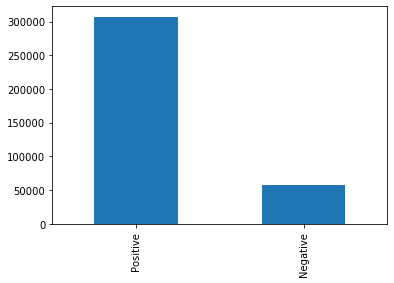

In [11]:
# Getting the number of positive and negative reviews

data['Score'].value_counts().plot(kind='bar')
data['Score'].value_counts()

### 2.2 Data Cleaning

In [12]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [13]:
# Find sentences containing html tags

i = 0
for sentence in data['Text'].values:
    if (len(re.findall('<.*?>', sentence))):
        print("Total number of html tags present:", i)
        print("=="*60)
        print(sentence)
        break
    i += 1

Total number of html tags present: 6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [14]:
# Function to remove texts with html tags(<...>)

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')                  # Select ANY text with < > tags
    cleanText = re.sub(cleanr, ' ', sentence)     # Replace texts enclosed in < > with white space
    return cleanText

In [15]:
# Function to remove punctuation marks(.,?/:;)

def cleanPunctuation(sentence):
    cleanp = re.sub(r'[?|$|.|!]',r'', sentence)
    cleanp = re.sub(r'[.|,|)|(|\|/]',r' ', cleanp)
    return cleanp

In [16]:
# Printing the set of stop words present in english language
# You need to download stopword first before using it(import nltk; nltk.download("stopwords");)

stopWords = set(stopwords.words('english'))
print(stopWords)

{"wasn't", 'theirs', 'again', 'most', 'why', 'just', 'hasn', 'wasn', 'ours', 'above', 'too', 'were', "mustn't", 'who', 'him', 'whom', 'has', 'y', 'your', 'we', 'while', 'be', 'there', 'both', "you've", 'after', 'from', "you're", 'a', 'ourselves', 'to', 'up', 'same', "don't", 'themselves', 'as', 'haven', 'on', 'his', 'its', 'because', 'other', 'yours', 'below', 'an', 'their', 'once', 'which', 'through', 's', 'ma', 'hers', 'down', 'under', 'being', 'further', 'she', 'no', 'if', 'of', 'couldn', 'd', 'won', 'over', 'them', 'about', 'had', 'own', 'doing', 'until', "aren't", 'didn', 'some', "shouldn't", 'yourselves', "it's", "you'd", 'they', 'don', "isn't", 'now', "didn't", 'shan', 'those', 'am', 'off', 'you', 'himself', 'here', 'my', 'into', 'before', 'nor', 'shouldn', 'i', "you'll", 'what', "couldn't", 'such', 'by', 'needn', 'that', 'very', 'or', "wouldn't", 'isn', 'more', 'not', 'each', 'having', 'aren', 'have', 'been', "should've", "won't", 'her', 'm', 'in', "she's", 'all', 'll', 'how', 

In [17]:
# Initializing SnowBall Stemmer

snowball = SnowballStemmer('english')

In [18]:
# Printing a base-word using snowball stemmer

print(snowball.stem('tasty'))
print(snowball.stem('delicious'))
print(snowball.stem('little'))

tasti
delici
littl


In [19]:
# Core Pre-processing code step-by-step(removing html tags, punctuations, stopwords, etc)
# This may take a few minutes to execute as it needs to execute all the sentences present in data['Text']

i = 0
initial_str = ''
final_str = []          # Store final string of clean words
positive_words = []     # Store words from positive reviews here
negative_words = []     # Store words from negative reviews here
s = ''

for sentence in data['Text'].values:
    filtered_sentence = []
    sentence = cleanHtml(sentence)          # Remove html tags
    for words in sentence.split():
        for word in cleanPunctuation(words).split():
            if ((word.isalpha()) & (len(word) > 2)):
                if (word.lower() not in stopWords):
                    s = (snowball.stem(word.lower()).encode('utf-8'))
                    filtered_sentence.append(s)
                    if ((data['Score'].values)[i] == 'Positive'):
                        positive_words.append(s)
                    if ((data['Score'].values)[i] == 'Negative'):
                        negative_words.append(s)
                else:
                    continue
            else:
                continue
    initial_str = b" ".join(filtered_sentence)      # Final string of clean words
    final_str.append(initial_str)
    i += 1

In [20]:
# Adding a column in dataset and storing cleaned text in it.

data['CleanedText'] = final_str
data['CleanedText'] = data['CleanedText'].str.decode("utf-8")

In [21]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


# 3. Time-based splitting of data

In [22]:
# Sorting data based on time

time_sort = data.sort_values('Time', ascending=True, axis=0, na_position='last')       # na_postion='last' puts NaNs at the end
time_sort.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# Splitting data into Train, Test and Cross-validation

X = time_sort['CleanedText']
Y = time_sort['Score']

x_training, x_test, y_training, y_test= train_test_split(X, Y, test_size=0.25)
x_train, x_cv, y_train, y_cv = train_test_split(x_training, y_training, test_size=0.3)

In [25]:
print("The shape of the training data is:", x_train.shape, y_train.shape)
print("The shape of the CV data is:", x_cv.shape, y_cv.shape)
print("The shape of the test data is:", x_test.shape, y_test.shape)

The shape of the training data is: (191168,) (191168,)
The shape of the CV data is: (81930,) (81930,)
The shape of the test data is: (91033,) (91033,)


# 4. Creating a function to Train and Test KNN models

In [26]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### 4.1 Train funcrion for KNN models

In [27]:
def knn_train(x_train, x_cv, y_train, y_cv, algo):
    k = []
    accuracy_cv = []

    for i in range(2, 25, 2):
        neighbor = KNeighborsClassifier(n_neighbors=i, algorithm=algo)
        neighbor.fit(x_train, y_train)
        
        prediction = neighbor.predict(x_cv)
        
        acc_cv = accuracy_score(y_cv, prediction)
        f1_cv = f1_score(y_cv, prediction, average='macro')
        precision_cv = precision_score(y_cv, prediction, average='macro')
        recall_cv = recall_score(y_cv, prediction, average='macro')
        
        print("FOR K =", i)
        print("The accuracy of the model is:", acc_cv*100)
        print("The f1_score of the model is:", f1_cv*100)
        print("The precision_score of the model is:", precision_cv*100)
        print("The recall_score of the model is:", recall_cv*100)
        print("=="*60)
        
        k.append(i)
        accuracy_cv.append(acc_cv)
        
    # Plot k vs auc_score graph
    plt.plot(k, accuracy_cv, 'b-', label="Cross Validation Data")
    plt.legend(loc='lower right')
    plt.title("K v/s Auc Score")
    plt.ylabel('Auc Score')
    plt.xlabel('K')
    plt.show()

### 4.2 Test funcrion for KNN models

In [28]:
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix

In [29]:
def knn_test(x_train, y_train, x_test, y_test, algo, optimal_k):
    neighbor = KNeighborsClassifier(n_neighbors=optimal_k, algorithm=algo) 
    neighbor.fit(x_train, y_train)
    
    prediction = neighbor.predict(x_test)

    print("The accuracy of the model is:", accuracy_score(y_test, prediction)*100)
    print("The macro f1_score of the model is:", f1_score(y_test, prediction, average = 'macro')*100)
    print("The micro f1_score of the model is:", f1_score(y_test, prediction, average = 'micro')*100)
    print("The precision_score of the model is:", precision_score(y_test, prediction, average='macro')*100)
    print("The recall_score of the model is:", recall_score(y_test, prediction, average='macro')*100)
    print("The precision recall report for data:\n", classification_report(y_test, prediction))
    
    plot_confusion_matrix(y_test, prediction)
    plt.show()

# 5. Vectorization of splitted of data

### 5.1 Bag of Words (BoW)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
count_vect = CountVectorizer(ngram_range=(2,2))
count_vect.fit(x_train)
# Fit should be done only to train data
# After fitting count_vect only learns the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_bow = count_vect.transform(x_train)
x_cv_bow = count_vect.transform(x_cv)
x_test_bow = count_vect.transform(x_test)

In [32]:
print("The shape of the training data is:", x_train_bow.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_bow.shape, y_cv.shape)
print("The shape of the test data is:", x_test_bow.shape, y_test.shape)

The shape of the training data is: (191168, 1863703) (191168,)
The shape of the CV data is: (81930, 1863703) (81930,)
The shape of the test data is: (91033, 1863703) (91033,)


### 5.2 Term Frequency - Inverse Document Frequency (tf-idf)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
tfidf_vect = TfidfVectorizer(stop_words=None, ngram_range=(1,2))
tfidf_vect.fit(x_train)
# Fit should be done only to train data
# After fitting tfidf_vect only learnss the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_tfidf = tfidf_vect.transform(x_train)
x_cv_tfidf = tfidf_vect.transform(x_cv)
x_test_tfidf = tfidf_vect.transform(x_test)

In [32]:
print("The shape of the training data is:", x_train_tfidf.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidf.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidf.shape, y_test.shape)

The shape of the training data is: (191168, 1925085) (191168,)
The shape of the CV data is: (81930, 1925085) (81930,)
The shape of the test data is: (91033, 1925085) (91033,)


### 5.3 Word2Vec

In [30]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm

In [31]:
sentence_list = []
for sentence in x_train:
    sentence_list.append(sentence.split())

In [32]:
sentence_list_cv = []
for sentence in x_cv:
    sentence_list_cv.append(sentence.split())

In [33]:
sentence_list_test = []
for sentence in x_test:
    sentence_list_test.append(sentence.split())

In [34]:
# Train your own Word2Vec model using your own train text corpus 

w2v_train_model = Word2Vec(sentence_list, min_count=5, size=50, workers=4)          # Considers only those words that occured atleast 5 times
print(type(w2v_train_model))

<class 'gensim.models.word2vec.Word2Vec'>


In [35]:
w2v_words = list(w2v_train_model.wv.vocab)
print("The number of words that occured minimum 5 times:", len(w2v_words))
print("These are the sample words from index 0 to 50:/n", w2v_words[0:50])

The number of words that occured minimum 5 times: 16438
These are the sample words from index 0 to 50:/n ['spent', 'year', 'look', 'low', 'calori', 'fat', 'dress', 'like', 'ago', 'found', 'vidalia', 'brand', 'sweet', 'onion', 'raspberri', 'vinaigrett', 'knew', 'immedi', 'search', 'yummi', 'healthi', 'veget', 'could', 'longer', 'find', 'local', 'store', 'start', 'order', 'onlin', 'want', 'without', 'help', 'weight', 'health', 'goal', 'great', 'snack', 'desert', 'plus', 'bonus', 'realli', 'tell', 'differ', 'chocol', 'tough', 'eat', 'whole', 'bag', 'one']


### 5.4 Average Word2Vec

In [36]:
avg_train_vector = []                         # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list):          # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_train_vector.append(sentence_vector)
avg_train_vector = np.array(avg_train_vector)

100%|██████████| 191168/191168 [00:21<00:00, 8865.30it/s]


In [37]:
print(avg_train_vector.shape)
print(avg_train_vector[0])

(191168, 50)
[ 0.62862751 -0.27735252  0.86835065 -0.61411911  1.06589568 -0.47329209
  0.14324177 -0.563572    0.23591785  0.749522    1.07128377 -0.05552739
  1.32256143 -0.32440567 -0.0110846   0.12213442  0.08350034 -0.04284255
  0.41245277 -0.19764048 -1.81309847  0.47555656 -0.13404346 -0.02719647
  1.03344868 -0.09058742 -0.40468668 -0.97062374 -0.1384321   0.59712194
  0.81154848  0.99789078  0.25482247 -0.06282113 -1.25008008  0.002388
 -0.21110159  2.3390995  -0.03000106  0.09073209 -0.04729315 -1.42501573
 -0.41001698  1.00802594  0.37482978 -0.61983113  0.84664829 -0.04350902
 -1.01066521  0.03124187]


In [38]:
avg_cv_vector = []                            # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_cv):       # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_cv_vector.append(sentence_vector)
avg_cv_vector = np.array(avg_cv_vector)

100%|██████████| 81930/81930 [00:09<00:00, 8795.94it/s]


In [39]:
print(avg_cv_vector.shape)
print(avg_cv_vector[0])

(81930, 50)
[ 0.07530848 -0.62738166 -0.02696957 -0.755237    0.12416798 -0.71864357
  0.16380859  0.08774618  0.11441729 -0.7574957   0.9748091   0.40848627
  0.32933499 -0.14787105  0.4419236   0.06562775 -0.24712285  0.30309213
  0.76748712 -0.22169089 -1.18692755  0.5896885  -0.83994709  0.16152977
  0.47048446 -0.5813387   0.6926413  -0.9789319   0.49718491  0.39784904
 -0.32864425  0.12307369  0.75027898  0.24326496 -0.01923601 -0.19627237
 -0.58285574  0.94580092 -0.71461539 -0.03344212 -0.19696062 -0.36617429
  0.78550357  0.29592782  0.40835986  0.19285268  0.19133535 -0.19186545
  0.01977453 -0.51080654]


In [40]:
avg_test_vector = []                          # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_test):     # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_test_vector.append(sentence_vector)
avg_test_vector = np.array(avg_test_vector)

100%|██████████| 91033/91033 [00:10<00:00, 8800.01it/s]


In [41]:
print(avg_test_vector.shape)
print(avg_test_vector[0])

(91033, 50)
[-0.90517382 -0.22138438  0.2183636  -0.52142329  0.19569448  0.49617738
 -0.89453634  0.03904357 -0.49731832 -1.13398159  0.6174483  -0.1762707
 -0.07658873 -0.40164344 -0.58209158  0.23590163 -0.17740942 -1.11642061
  0.15066979  0.40014644 -0.11383272 -0.47577177  0.17718595 -0.31020709
  0.10037663 -1.14404895  0.53984576 -0.46216297 -0.37851823 -0.10703729
  1.05833969 -0.26077589 -0.11111518 -1.06587019 -0.87263052  0.79742144
 -0.45081135  1.9634269  -0.53884431 -0.0306679   0.54157047 -0.3895925
 -0.93033794 -0.11319753  0.60349948 -0.39554757  0.75692695 -0.17109515
  0.23987639  0.40398665]


In [42]:
# Checking if the model has NULL values ins the list avg_train_vector

pd.isnull(avg_train_vector)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [43]:
x_train_avgw2v = avg_train_vector
x_cv_avgw2v = avg_cv_vector
x_test_avgw2v = avg_test_vector

In [44]:
print("The shape of the training data is:", x_train_avgw2v.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_avgw2v.shape, y_cv.shape)
print("The shape of the test data is:", x_test_avgw2v.shape, y_test.shape)

The shape of the training data is: (191168, 50) (191168,)
The shape of the CV data is: (81930, 50) (81930,)
The shape of the test data is: (91033, 50) (91033,)


### 5.5 TF-IDF Weighed Word2Vec

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tfidf_vect.fit_transform(x_train)
tfidf_feat = tfidf_vect.get_feature_names()
dictionary = dict(zip(tfidf_feat, list(tfidf_vect.idf_)))

In [38]:
tfidf_train_vector = []                         # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list):            # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_train_vector.append(sentence_vector)
tfidf_train_vector = np.array(tfidf_train_vector)

100%|██████████| 191168/191168 [00:43<00:00, 4366.37it/s]


In [39]:
print(tfidf_train_vector.shape)
print(tfidf_train_vector[0])

(191168, 50)
[ 0.7715307  -0.65049895  1.20718082 -0.78353549  0.08307408  0.11026174
 -0.58552086 -0.36988362  1.10421928  0.91739887  0.02548137  0.92605932
 -0.25017393  0.59020416 -0.32050749  0.27332844  0.80769564  0.14878424
  0.25246326  0.13963537 -0.03721084  0.15397323 -0.31083295 -0.5594245
 -1.41644406 -0.87228132 -0.42077684 -0.25189404  0.0861041  -1.07016689
 -0.17438439 -1.02240246 -0.45013412  0.08550297 -0.45428355 -0.99199111
 -0.0227376   1.31178801 -0.27266075  0.51150999  0.10748062  0.75998302
  0.75006535  0.64021338  0.84450019  0.16975038  0.43650763  0.23690266
  1.71431511  0.62042428]


In [40]:
tfidf_cv_vector = []                            # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_cv):         # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_cv_vector.append(sentence_vector)
tfidf_cv_vector = np.array(tfidf_cv_vector)

100%|██████████| 81930/81930 [00:18<00:00, 4337.06it/s]


In [41]:
print(tfidf_cv_vector.shape)
print(tfidf_cv_vector[0])

(81930, 50)
[ 0.39622486 -1.43840692  1.16705507 -0.09464913  0.10150591 -1.54523562
 -1.06084564  0.90750107  1.46738764  0.16077546 -0.05268383  0.91406421
  1.61333337 -0.21232851 -0.77209839 -0.43597765 -0.27781404 -0.21982855
 -0.15249143 -0.95143719  1.03395161  0.38359129  0.28819038 -1.48275908
 -0.77180402 -0.76586546  0.44995828 -0.13309167  0.87639938  1.0116146
 -0.54756909 -1.43776667 -0.78284426  0.36726026 -0.46815196 -0.93403563
 -0.03948464  0.67418559  0.11982913  0.28138699 -0.90197483  0.66408179
  1.51381031 -0.35717887  1.04718196  0.77251486 -0.98466935 -0.36033055
  1.39853943 -0.21824931]


In [42]:
tfidf_test_vector = []                          # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_test):       # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_test_vector.append(sentence_vector)
tfidf_test_vector = np.array(tfidf_test_vector)

100%|██████████| 91033/91033 [00:20<00:00, 4376.25it/s]


In [43]:
print(tfidf_test_vector.shape)
print(tfidf_test_vector[0])

(91033, 50)
[-0.6788895  -0.28729244  0.96102541 -0.45665035  0.33345471 -0.17194128
 -0.54122298  0.86410863  0.68896058 -0.76865769 -0.71778557  1.04069566
  0.75939315 -0.33014691 -0.35372607 -1.50317652 -1.02462211  0.14347505
  0.96344743  0.34569375  0.39337927  0.17487568  0.45579708 -0.75526061
  0.86128301 -0.60842021  0.37879925 -0.49773199  0.75346648  1.1385598
  0.51965783 -1.08840326 -0.64084349  1.07072618 -0.90068185 -0.6875844
  0.11903791 -1.01042391  0.93471752  0.73059284  0.7646278   0.37432319
  1.13540191  0.12479639 -0.12112609  0.68597869 -0.29120354  0.01706832
  0.63441466  1.14144942]


In [44]:
x_train_tfidfw2v = tfidf_train_vector
x_cv_tfidfw2v = tfidf_cv_vector
x_test_tfidfw2v = tfidf_test_vector

In [45]:
print("The shape of the training data is:", x_train_tfidfw2v.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidfw2v.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidfw2v.shape, y_test.shape)

The shape of the training data is: (191168, 50) (191168,)
The shape of the CV data is: (81930, 50) (81930,)
The shape of the test data is: (91033, 50) (91033,)


# 6. Applying KNN Brute Force on Our Model

### 6.1 Bag of Words (BoW)

##### 6.1.1 BoW KNN Brute Force on Train Data

FOR K = 2
The accuracy of the model is: 17.966556816794824
The f1_score of the model is: 16.55390703402162
The precision_score of the model is: 52.07945851493865
The recall_score of the model is: 50.4262316559973
FOR K = 4
The accuracy of the model is: 70.5883070914195
The f1_score of the model is: 50.51809166624709
The precision_score of the model is: 50.64007096640525
The recall_score of the model is: 50.78313050051708
FOR K = 6
The accuracy of the model is: 84.12181130233127
The f1_score of the model is: 47.204062741284716
The precision_score of the model is: 64.55145626155593
The recall_score of the model is: 50.607418303078035
FOR K = 8
The accuracy of the model is: 84.19382399609422
The f1_score of the model is: 46.10474958923592
The precision_score of the model is: 70.06996992842184
The recall_score of the model is: 50.17087830645295
FOR K = 10
The accuracy of the model is: 84.1950445502258
The f1_score of the model is: 45.99173088099145
The precision_score of the model is: 71.9

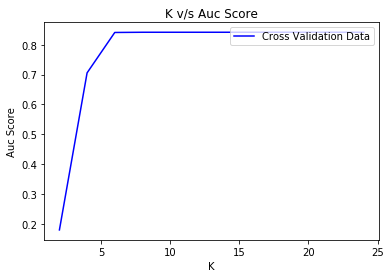

In [33]:
# Find the optimal value of K
# This may take several minutes(even hour/s) to run

knn_train(x_train_bow, x_cv_bow, y_train, y_cv, algo='brute')

##### 6.1.2 BoW KNN Brute Force on Test Data

The accuracy of the model is: 84.32875990025596
The macro f1_score of the model is: 45.84633982647454
The micro f1_score of the model is: 84.32875990025596
The precision_score of the model is: 73.98506274466324
The recall_score of the model is: 50.043836105667914
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.64      0.00      0.00     14272
    Positive       0.84      1.00      0.91     76761

    accuracy                           0.84     91033
   macro avg       0.74      0.50      0.46     91033
weighted avg       0.81      0.84      0.77     91033



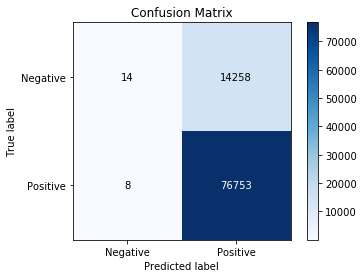

In [41]:
# Testing the final model

knn_test(x_train_bow, y_train, x_test_bow, y_test, algo='brute', optimal_k=18)

### 6.2 Term Frequency - Inverse Document Frequency (tf-idf)

##### 6.2.1 TF-IDF KNN Brute Force on Train Data

FOR K = 2
The accuracy of the model is: 84.65397290369829
The f1_score of the model is: 47.21906685176988
The precision_score of the model is: 84.54425296936958
The recall_score of the model is: 50.679831531283234
FOR K = 4
The accuracy of the model is: 85.40583424874893
The f1_score of the model is: 58.44503648151475
The precision_score of the model is: 74.10447380893291
The recall_score of the model is: 56.935799837915425
FOR K = 6
The accuracy of the model is: 85.9160258757476
The f1_score of the model is: 59.36443318112903
The precision_score of the model is: 78.14917554192029
The recall_score of the model is: 57.532975186835976
FOR K = 8
The accuracy of the model is: 86.14915171487856
The f1_score of the model is: 59.41422882506057
The precision_score of the model is: 80.88568665667218
The recall_score of the model is: 57.545819805671464
FOR K = 10
The accuracy of the model is: 86.19309166361529
The f1_score of the model is: 59.05734798487159
The precision_score of the model is: 8

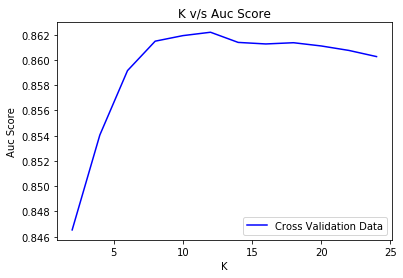

In [33]:
# Find the optimal value of K
# This may take several minutes(even hour/s) to run

knn_train(x_train_tfidf, x_cv_tfidf, y_train, y_cv, algo='brute')

##### 6.2.2 TF-IDF KNN Brute Force on Test Data

The accuracy of the model is: 86.0676897388859
The macro f1_score of the model is: 58.72234766583724
The micro f1_score of the model is: 86.0676897388859
The precision_score of the model is: 83.98849962108666
The recall_score of the model is: 57.112345123169085
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.82      0.15      0.25     14337
    Positive       0.86      0.99      0.92     76696

    accuracy                           0.86     91033
   macro avg       0.84      0.57      0.59     91033
weighted avg       0.85      0.86      0.82     91033



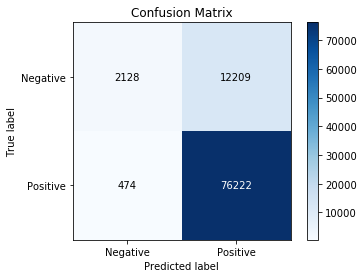

In [34]:
# Testing the final model

knn_test(x_train_tfidf, y_train, x_test_tfidf, y_test, algo='brute', optimal_k=12)

### 6.3 Average Word2Vec

##### 6.3.1 Avg W2V KNN Brute Force on Train Data

FOR K = 2
The accuracy of the model is: 81.84547784694252
The f1_score of the model is: 70.45003859713259
The precision_score of the model is: 68.49759635697535
The recall_score of the model is: 74.1074481845198
FOR K = 4
The accuracy of the model is: 86.760649334798
The f1_score of the model is: 73.95664984743577
The precision_score of the model is: 75.06293974088554
The recall_score of the model is: 73.00803744471519
FOR K = 6
The accuracy of the model is: 88.02636396924204
The f1_score of the model is: 74.48358428693248
The precision_score of the model is: 78.59480407955321
The recall_score of the model is: 71.85710733129395
FOR K = 8
The accuracy of the model is: 88.34614915171488
The f1_score of the model is: 74.03033361263857
The precision_score of the model is: 80.30029866265394
The recall_score of the model is: 70.65680002826643
FOR K = 10
The accuracy of the model is: 88.52068839253022
The f1_score of the model is: 73.73353836898582
The precision_score of the model is: 81.5034

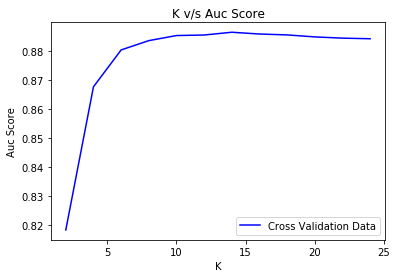

In [49]:
# Find the optimal value of K
# This may take several minutes(even hour/s) to run

knn_train(x_train_avgw2v, x_cv_avgw2v, y_train, y_cv, algo='brute')

##### 6.3.2 Avg W2V KNN Brute Force on Test Data

The accuracy of the model is: 88.81394659079675
The macro f1_score of the model is: 73.72023421612728
The micro f1_score of the model is: 88.81394659079675
The precision_score of the model is: 83.32099730189277
The recall_score of the model is: 69.54314754143651
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.77      0.41      0.54     14312
    Positive       0.90      0.98      0.94     76721

    accuracy                           0.89     91033
   macro avg       0.83      0.70      0.74     91033
weighted avg       0.88      0.89      0.87     91033



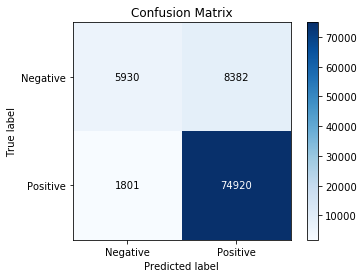

In [50]:
# Testing the final model

knn_test(x_train_avgw2v, y_train, x_test_avgw2v, y_test, algo='brute', optimal_k=14)

### 6.4 TF-IDF Weighed Word2Vec

##### 6.4.1 TF_IDF W2V KNN Brute Force on Train Data

FOR K = 2
The accuracy of the model is: 77.042597339192
The f1_score of the model is: 63.70237186887714
The precision_score of the model is: 62.42854571647249
The recall_score of the model is: 66.98115364997567
FOR K = 4
The accuracy of the model is: 83.45905040888564
The f1_score of the model is: 66.5982247095232
The precision_score of the model is: 67.93022360885297
The recall_score of the model is: 65.58895000354859
FOR K = 6
The accuracy of the model is: 85.07262297082876
The f1_score of the model is: 66.0780834872641
The precision_score of the model is: 71.17678226966227
The recall_score of the model is: 63.73504329898155
FOR K = 8
The accuracy of the model is: 85.63285731722202
The f1_score of the model is: 65.11541250954697
The precision_score of the model is: 73.27338144398901
The recall_score of the model is: 62.380151733053836
FOR K = 10
The accuracy of the model is: 85.93921640424753
The f1_score of the model is: 64.40407951927911
The precision_score of the model is: 75.0336

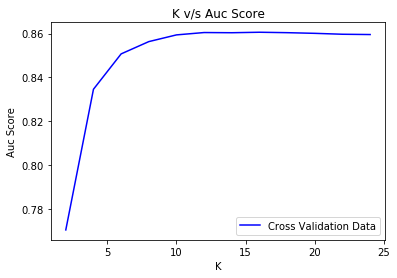

In [53]:
# Find the optimal value of K
# This may take several minutes(even hour/s) to run

knn_train(x_train_tfidfw2v, x_cv_tfidfw2v, y_train, y_cv, algo='brute')

##### 6.4.2 TF_IDF W2V KNN Brute Force on Test Data

The accuracy of the model is: 85.9501499456241
The macro f1_score of the model is: 63.221535731700264
The micro f1_score of the model is: 85.9501499456241
The precision_score of the model is: 76.08696562461792
The recall_score of the model is: 60.48069276692581
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.65      0.23      0.34     14329
    Positive       0.87      0.98      0.92     76704

    accuracy                           0.86     91033
   macro avg       0.76      0.60      0.63     91033
weighted avg       0.84      0.86      0.83     91033



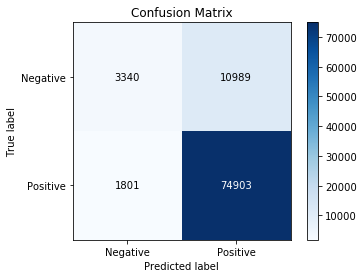

In [54]:
# Testing the final model

knn_test(x_train_tfidfw2v, y_train, x_test_tfidfw2v, y_test, algo='brute', optimal_k=12)

# 7. Applying KNN KD - Tree on Our Model

In [46]:
from sklearn.decomposition import TruncatedSVD

### 7.1 Bag of Words (BoW)

##### 7.1.1 BoW KNN KD Tree on Train Data

In [34]:
# KD_Tree algorithm does not work well with sparse metrix.
# So, to make the metrix dense(i.e. to reduce dimension of the metrix) we use TruncatedSVD.
# Here we are using TruncatedSVD with 1000 features.
# This may take several minutes to run

tsvd = TruncatedSVD(n_components=1000)

x_train_bow = tsvd.fit_transform(x_train_bow)
x_cv_bow = tsvd.fit_transform(x_cv_bow)
x_test_bow = tsvd.fit_transform(x_test_bow)

In [35]:
print("The shape of the training data is:", x_train_bow.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_bow.shape, y_cv.shape)
print("The shape of the test data is:", x_test_bow.shape, y_test.shape)

The shape of the training data is: (191168, 1000) (191168,)
The shape of the CV data is: (81930, 1000) (81930,)
The shape of the test data is: (91033, 1000) (91033,)


Text(0, 0.5, 'Cumulative Explained Variance')

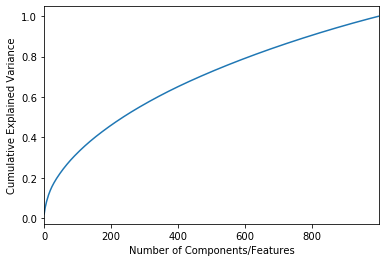

In [37]:
tsvd_plot = TruncatedSVD(n_components=999).fit(x_train_bow)
plt.plot(np.cumsum(tsvd_plot.explained_variance_ratio_))
plt.xlim(0, 999, 10)
plt.xlabel('Number of Components/Features')
plt.ylabel('Cumulative Explained Variance')

In [ ]:
# Find the optimal value of K
# This may take several minutes(even hour/s) to run

knn_train(x_train_bow, x_cv_bow, y_train, y_cv, algo='kd_tree')

This cell was left unexecuted because it took quite long to execute in my machine. However, the code is completely good to go with.

##### 7.1.2 BoW KNN KD Tree on Test Data

In [ ]:
# Testing the final model

knn_test(x_train_bow, y_train, x_test_bow, y_test, algo='kd_tree', optimal_k=k)

This cell was left unexecuted because it took quite long to execute in my machine. However, the code is completely good to go with.

### 7.2 Term Frequency - Inverse Document Frequency (TF-IDF)

##### 7.2.1 TF-IDF KNN KD Tree on Train Data

Text(0, 0.5, 'Cumulative Explained Variance')

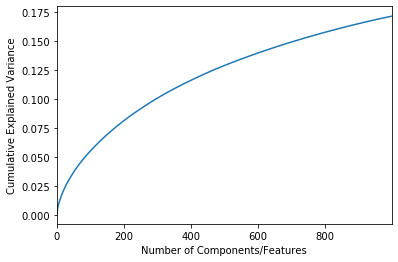

In [34]:
tsvd_plot = TruncatedSVD(n_components=999).fit(x_train_tfidf)
plt.plot(np.cumsum(tsvd_plot.explained_variance_ratio_))
plt.xlim(0, 999, 10)
plt.xlabel('Number of Components/Features')
plt.ylabel('Cumulative Explained Variance')

In [35]:
tsvd = TruncatedSVD(n_components=1000)

In [36]:
# KD_Tree algorithm does not work well with sparse metrix.
# So, to make the metrix dense(i.e. to reduce dimension of the metrix) we use TruncatedSVD.
# Here we are using TruncatedSVD with 1000 features.

x_train_tfidf = tsvd.fit_transform(x_train_tfidf)
x_cv_tfidf = tsvd.fit_transform(x_cv_tfidf)
x_test_tfidf = tsvd.fit_transform(x_test_tfidf)

In [37]:
print("The shape of the training data is:", x_train_tfidf.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidf.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidf.shape, y_test.shape)

The shape of the training data is: (191168, 1000) (191168,)
The shape of the CV data is: (81930, 1000) (81930,)
The shape of the test data is: (91033, 1000) (91033,)


In [ ]:
# Find the optimal value of K
# This may take several minutes(even hour/s) to run

knn_train(x_train_tfidf, x_cv_tfidf, y_train, y_cv, algo='kd_tree')

This cell was left unexecuted because it took quite long to execute in my machine. However, the code is completely good to go with.

##### 7.2.2 TF-IDF KNN KD Tree on Test Data

In [ ]:
# Testing the final model

knn_test(x_train_tfidf, y_train, x_test_tfidf, y_test, algo='kd_tree', optimal_k=k)

This cell was left unexecuted because it took quite long to execute in my machine. However, the code is completely good to go with.

### 7.3 Average Word2Vec

##### 7.3.1 Avg W2V KNN KD Tree on Train Data

Text(0, 0.5, 'Cumulative Explained Variance')

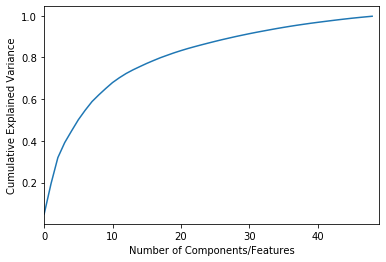

In [48]:
tsvd_plot = TruncatedSVD(n_components=49).fit(x_train_avgw2v)
plt.plot(np.cumsum(tsvd_plot.explained_variance_ratio_))
plt.xlim(0, 49, 10)
plt.xlabel('Number of Components/Features')
plt.ylabel('Cumulative Explained Variance')

In [52]:
tsvd = TruncatedSVD(n_components=49)

In [53]:
# KD_Tree algorithm does not work well with sparse metrix.
# So, to make the metrix dense(i.e. to reduce dimension of the metrix) we use TruncatedSVD.
# Here we are using TruncatedSVD with 1000 features.

x_train_avgw2v = tsvd.fit_transform(x_train_avgw2v)
x_cv_avgw2v = tsvd.fit_transform(x_cv_avgw2v)
x_test_avgw2v = tsvd.fit_transform(x_test_avgw2v)

In [54]:
print("The shape of the training data is:", x_train_avgw2v.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_avgw2v.shape, y_cv.shape)
print("The shape of the test data is:", x_test_avgw2v.shape, y_test.shape)

The shape of the training data is: (191168, 49) (191168,)
The shape of the CV data is: (81930, 49) (81930,)
The shape of the test data is: (91033, 49) (91033,)


In [ ]:
# Find the optimal value of K
# This may take several minutes(even hour/s) to run

knn_train(x_train_avgw2v, x_cv_avgw2v, y_train, y_cv, algo='kd_tree')

This cell was left unexecuted because it took quite long to execute in my machine. However, the code is completely good to go with.

##### 7.3.2 Avg W2V KNN KD Tree on Test Data

In [ ]:
# Testing the final model

knn_test(x_train_avgw2v, y_train, x_test_avgw2v, y_test, algo='kd_tree', optimal_k=k)

This cell was left unexecuted because it took quite long to execute in my machine. However, the code is completely good to go with.

### 7.4 TF-IDF Weighed Word2Vec

##### 7.4.1 TF-IDF Weighed W2V KNN KD Tree on Train Data

Text(0, 0.5, 'Cumulative Explained Variance')

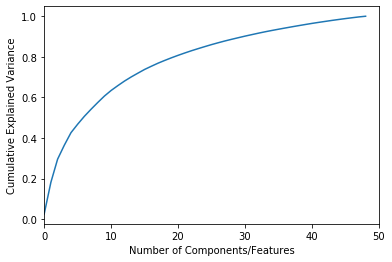

In [47]:
tsvd_plot = TruncatedSVD(n_components=49).fit(x_train_tfidfw2v)
plt.plot(np.cumsum(tsvd_plot.explained_variance_ratio_))
plt.xlim(0, 50, 5)
plt.xlabel('Number of Components/Features')
plt.ylabel('Cumulative Explained Variance')

In [48]:
tsvd = TruncatedSVD(n_components=49)

In [49]:
# KD_Tree algorithm does not work well with sparse metrix.
# So, to make the metrix dense(i.e. to reduce dimension of the metrix) we use TruncatedSVD.
# Here we are using TruncatedSVD with 1000 features.

x_train_tfidfw2v = tsvd.fit_transform(x_train_tfidfw2v)
x_cv_tfidfw2v = tsvd.fit_transform(x_cv_tfidfw2v)
x_test_tfidfw2v = tsvd.fit_transform(x_test_tfidfw2v)

In [50]:
print("The shape of the training data is:", x_train_tfidfw2v.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidfw2v.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidfw2v.shape, y_test.shape)

The shape of the training data is: (191168, 49) (191168,)
The shape of the CV data is: (81930, 49) (81930,)
The shape of the test data is: (91033, 49) (91033,)


In [ ]:
# Find the optimal value of K
# This may take several minutes(even hour/s) to run

knn_train(x_train_tfidfw2v, x_cv_tfidfw2v, y_train, y_cv, algo='kd_tree')

This cell was left unexecuted because it took quite long to execute in my machine. However, the code is completely good to go with.

##### 7.4.2 TF-IDF Weighed W2V KNN KD Tree on Test Data

In [ ]:
# Testing the final model

knn_test(x_train_tfidfw2v, y_train, x_test_tfidfw2v, y_test, algo='kd_tree', optimal_k=k)

This cell was left unexecuted because it took quite long to execute in my machine. However, the code is completely good to go with.